In [1]:
### check out glider data - from AOML ftp
# 2022 Hurricane Fiona cases south of Puerto Rico 
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
import seawater as sw
import csv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from compute_distance import distance
from convert_time import datetime_to_yearday

In [2]:
### glider info
year = '2022'
SG_num = '678'# '649' #'610' 
path_glider = '/Users/chi/Documents/Data/Glider/AOML/SG'+SG_num+'/M12JUL'+year+'/'
###
filenames_all = np.sort( os.listdir(path_glider) )
filenames = np.array([])
for file in filenames_all:
    if ('.nc' in file):
        filenames = np.append(filenames, file)
print(len(filenames),'Files have ".nc" in directory')
### the list of variables I want
vars_append = ['latitude','longitude','ctd_time','ctd_depth','ctd_pressure','temperature','salinity','density']
### create empty array to append later
for var_str in vars_append:
    str_exec = var_str+'= np.array([])'
    exec(str_exec)

1510 Files have ".nc" in directory


In [ ]:
### go through eacy nc file & append the variables? 
# (took ~26 sec for SG610, ~19 sec for SG649, ~27 sec for SG678)
for f in range( len(filenames) ):
    ds_file = nc.Dataset(path_glider+'/'+filenames[f])
    for var_str in vars_append:
        data_append = ds_file.variables[var_str][:]
        # print('file',f,var_str,'has', len(data_append),'data point')
        str_exec = var_str +'= np.append('+var_str+', data_append)'
        exec(str_exec)
print('total has',len(longitude),'data point in '+path_glider)

total has 831979 data point in /Users/chi/Documents/Data/Glider/AOML/SG678/M12JUL2022/


In [4]:
### convert to datetime
dtime_ctd = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=sec) for sec in ctd_time])
yday_ctd = np.nan*np.ones( (len(dtime_ctd),) )
for i in range( len(dtime_ctd) ):
    _, yday_ctd[i] = datetime_to_yearday(dtime_ctd[i])

<Figure size 432x288 with 0 Axes>

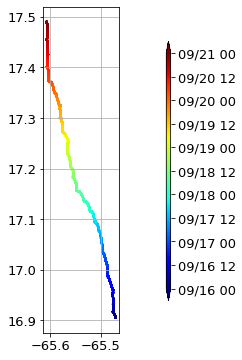

In [5]:
### plot locations on map
tlim_plot = [datetime.datetime(int(year),9,16),datetime.datetime(int(year),9,21)] # SG 610
it_plot = np.where( (dtime_ctd>= tlim_plot[0]) & (dtime_ctd< tlim_plot[1]) )[0]
nt = ((tlim_plot[1]-tlim_plot[0]).days)*2+1
dticks = [tlim_plot[0]+datetime.timedelta(days=0.5*i) for i in range(nt)]
tticks_label = [dticks[i].strftime('%m/%d %H') for i in range(len(dticks))]
tticks = np.nan*np.ones( (len(dticks),) )
for i, x in enumerate(dticks):
    _, tticks[i] = datetime_to_yearday(x)

###
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 6)
sc = plt.scatter( longitude[it_plot], latitude[it_plot], c=yday_ctd[it_plot], s=1, \
                 vmin=np.nanmin(yday_ctd[it_plot]), vmax=np.nanmax(yday_ctd[it_plot]), cmap='jet')
ax.set_aspect('equal', adjustable='box')
plt.grid()
cbar_ax = fig.add_axes([.71,.2,.01,.6])
axf = plt.colorbar(sc,orientation='vertical',cax=cbar_ax,extend='both')
axf.set_ticks(tticks)
axf.set_ticklabels(tticks_label)
# cbar_ax.set_title('yday',fontsize=13) # fraction day of the month
### save to figure
plt.savefig('scatter_lon-lat_c=yday_'+year+'-SG'+SG_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

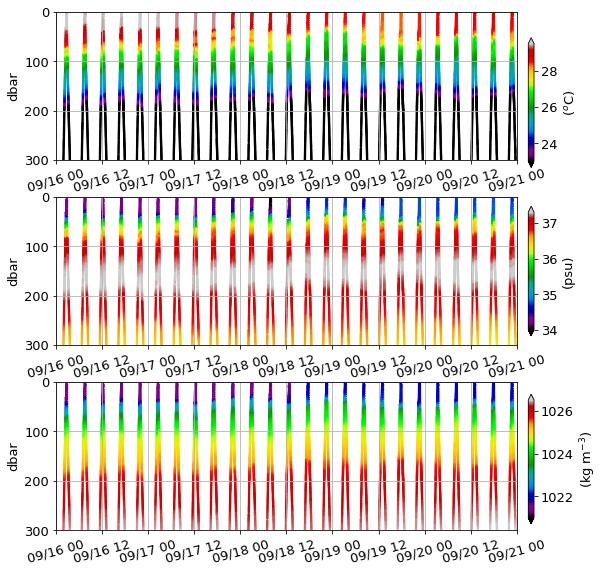

In [6]:
### plot time-depth T, S, Density 
vars_plot = ['temperature','salinity','density']
vars_lim = [[23,29.5],[34,37.3],[1021,1026.5]]
vars_unit = ['$^o$C','psu','kg m$^{-3}$']
ylim = [0,300]
nrow = len(vars_plot)
y0_nrow = [0.66,0.4,0.11]; dy = 0.2
### plot settings
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(8, 9)
plt.rcParams.update({'font.size': 13})
###
for i, var_str in enumerate( vars_plot ):
    plt.subplot(nrow,1,i+1)
    sc = plt.scatter(dtime_ctd[it_plot], ctd_pressure[it_plot], c=eval(var_str+'[it_plot]'),s=2, cmap='nipy_spectral',\
                     vmin=vars_lim[i][0], vmax=vars_lim[i][1])
    ###
    plt.xlim(tlim_plot)
    plt.ylim(ylim)
    plt.gca().invert_yaxis()
    plt.ylabel('dbar')
    plt.xticks(dticks,rotation=15)
    plt.gca().set_xticklabels(tticks_label)
    plt.grid()
    ### add colorbar
    cbar_ax = fig.add_axes([0.92,y0_nrow[i],.01,dy])
    axf = plt.colorbar(sc,orientation='vertical',cax=cbar_ax,extend='both')
    # cbar_ax.set_title('('+vars_unit[i]+')',fontsize=13)
    axf.set_label('('+vars_unit[i]+')', rotation=90)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.25)
### save to figure
plt.savefig('scatter_time-pres({:.0f}-{:.0f}dbar)_c=T-S-potden_'.format(ylim[0],ylim[1])+year+'-SG'+SG_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

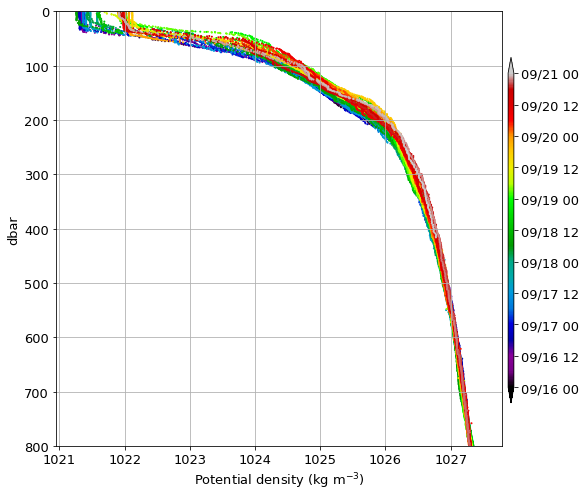

In [7]:
### plot vertical profiles - check where the ML, main pycnocline are
nrow = 1
### plot settings
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(8, 8)
plt.rcParams.update({'font.size': 13})
### 
sc = plt.scatter( density[it_plot], ctd_pressure[it_plot], c=yday_ctd[it_plot], s=1, \
                 vmin=np.nanmin(yday_ctd[it_plot]), vmax=np.nanmax(yday_ctd[it_plot]), cmap='nipy_spectral' )
plt.ylim([0,800])
plt.gca().invert_yaxis()
plt.ylabel('dbar')
plt.xlabel('Potential density (kg m$^{-3}$)')
plt.grid()
### colorbar
cbar_ax = fig.add_axes([.91,.2,.01,.6])
axf = plt.colorbar(sc,orientation='vertical',cax=cbar_ax,extend='both')
axf.set_ticks(tticks)
axf.set_ticklabels(tticks_label)
### save to figure
plt.savefig('scatter_potden-pres_c=yday_'+year+'-SG'+SG_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

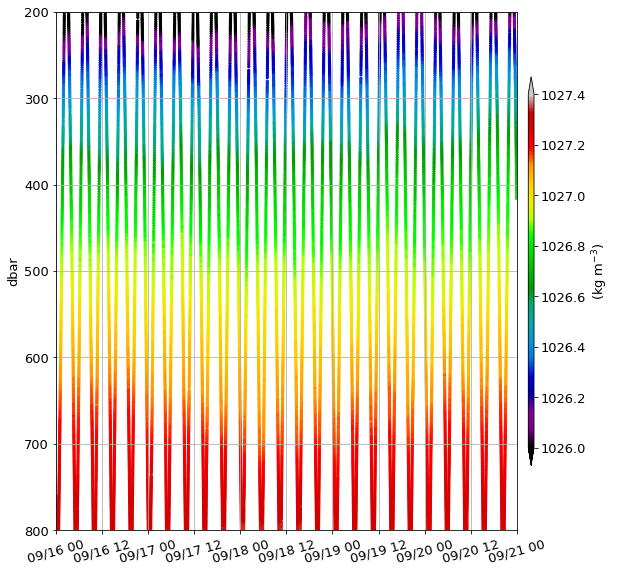

In [8]:
### plot time-depth T, S, Density 
vars_plot = ['density']
vars_lim = [[1026,1027.4]] #[[1024,1026.2]]
vars_unit = ['kg m$^{-3}$']
ylim = [200,800]#[75,200]
nrow = len(vars_plot)
y0_nrow = [0.2]; dy = 0.6
### plot settings
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(8, 9)
plt.rcParams.update({'font.size': 13})
###
for i, var_str in enumerate( vars_plot ):
    plt.subplot(nrow,1,i+1)
    sc = plt.scatter(dtime_ctd[it_plot], ctd_pressure[it_plot], c=eval(var_str+'[it_plot]'),s=5, cmap='nipy_spectral',\
                     vmin=vars_lim[i][0], vmax=vars_lim[i][1])
    ###
    plt.xlim(tlim_plot)
    plt.ylim(ylim)
    plt.gca().invert_yaxis()
    plt.ylabel('dbar')
    plt.xticks(dticks,rotation=15)
    plt.gca().set_xticklabels(tticks_label)
    plt.grid()
    ### add colorbar
    cbar_ax = fig.add_axes([0.92,y0_nrow[i],.01,dy])
    axf = plt.colorbar(sc,orientation='vertical',cax=cbar_ax,extend='both')
    # cbar_ax.set_title('('+vars_unit[i]+')',fontsize=13)
    axf.set_label('('+vars_unit[i]+')', rotation=90)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.25)
### save to figure
plt.savefig('scatter_time-pres({:.0f}-{:.0f}dbar)_c=potden_'.format(ylim[0],ylim[1])+year+'-SG'+SG_num+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')